# Дисперсионный анализ


## Описание данных:

### Датасет №1. Результат тестирования разрешения фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные<br>



| Поле   | Описание                                                                                                 |
| :------| :--------------------------------------------------------------------------------------------------------|
| id     | id клиента в эксперименте                                                                                |
| group  | в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)|
| events | сколько блюд суммарно было заказано за период                                                            |

### Датасет №2. Содержит результаты тестирования обновления кнопки заказа - часть пользователей видела старый вариант, а часть – новый<br>

| Поле        | Описание                                                 |
| :-----------| :--------------------------------------------------------|
| id          | id клиента в эксперименте                                |
| segment     | сегмент (high/low)                                       |
| group       | вид кнопки (control – старая версия, test – новая версия)|
| events      | сколько блюд суммарно было заказано за период            | 

## Постановка задачи

Вы работаете в приложении по доставке готовых продуктов. К вам пришел коллега с результатами двух тестов:
- В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
- Во втором: была обновлена кнопка заказа, и часть пользователей видела старый вариант, а часть – новый.

Коллега пришел к вам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия.<br>

Ваша задача – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

<hr>

In [1]:
# Импорт библиотек
import pandas as pd
import numpy as np

from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
import pingouin as pg

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

<hr>

## 1. Проверим, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего.


### Cформулируем гипотезы для проверки:

- **Нулевая гипотеза** $(H_0)$: Ни одно из выборочных средних не отличается от другого (нет различий)
- **Альтернативная гипотеза** $(H_1)$:  Хотя бы одно выборочное среднее отличается от других (есть различия как минимум между двумя группами)

In [2]:
# Загрузим датасет №1, посмотрим на их размерность и отобразим первые 5 строк
photos_df = pd.read_csv('experiment_photos.csv')
print(f'Размерность данных "photos_df" - {photos_df.shape}')
photos_df.head()

Размерность данных "photos_df" - (30000, 3)


,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


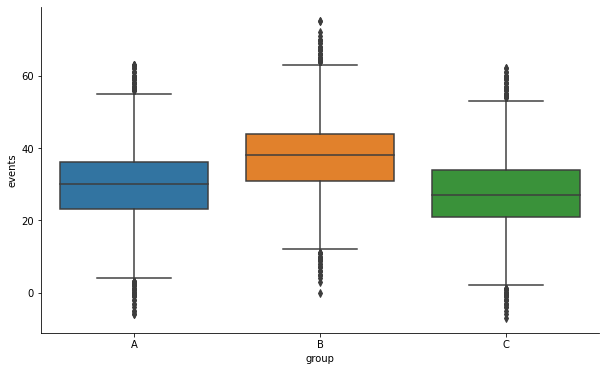

In [3]:
# Визуализурем данные по группам
plt.figure(figsize=(10, 6))
sns.boxplot(x='group', y='events', data=photos_df)
sns.despine();

### 1.1 Тестируем различие в дисперсиях


**Нулевая гипотеза** $(H_0)$: Дисперсии гомогенны<br>
**Альтернативная гипотеза** $(H_1)$: Дисперсии гетерогенны (различаются)

In [4]:
# Используем тест Левена
pg.homoscedasticity(data=photos_df, dv='events', group='group')

,W,pval,equal_var
levene,2.26226,0.104133,True


**$p$-value $> 0.05$, не отклоняем нулевую гипотезу**

### 2.1 Проверим выполнение условий на нормальность


Сделаем семплирование перед применением теста Шапиро-Уилка при проверке на нормальность, так как на больших выборках можем получать неверные результаты. Поэтому берём случайные 1000 значений из выборки, чтобы обойти этот недостаток. Будем также использовать аргумент ```random_state=17``` для стабильности и воспроизводимости результатов.

In [5]:
# Формируем случайную выборку размером 1000 наблюдений из каждой группы
a_sample = photos_df[photos_df['group'] == 'A'].events.sample(1000, random_state=17)
b_sample = photos_df[photos_df['group'] == 'B'].events.sample(1000, random_state=17)
c_sample = photos_df[photos_df['group'] == 'C'].events.sample(1000, random_state=17)

In [6]:
# Применим тест Шапиро-Уилка для выборки из группы А
shapiro(a_sample)

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [7]:
# Применим тест Шапиро-Уилка для выборки из группы В
shapiro(b_sample)

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [8]:
# Применим тест Шапиро-Уилка для выборки из группы С
shapiro(c_sample)

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

**Сравним полученные результаты с normaltest, а также qq-графиками**

In [9]:
# Используем функцию normality
pg.normality(data=photos_df, dv='events', group='group', method='normaltest')

,W,pval,normal
A,2.103460,0.349333,True
B,0.841072,0.656695,True
C,3.243726,0.197530,True


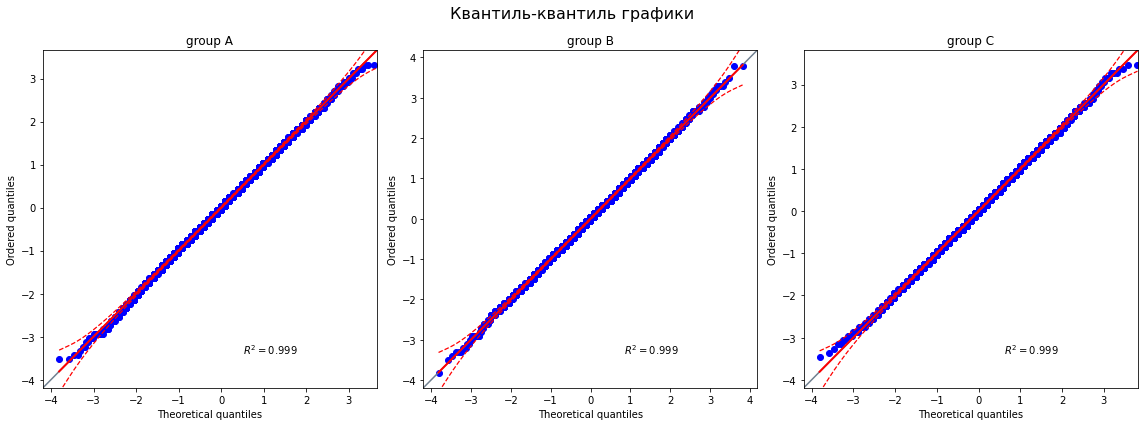

In [10]:
# построим Q-Q Plot 
a = photos_df[photos_df['group'] == 'A'].events
b = photos_df[photos_df['group'] == 'B'].events
c = photos_df[photos_df['group'] == 'C'].events

data_to_plot = [a, b, c]

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 6))
fig.suptitle('Квантиль-квантиль графики', fontsize=16)

for ax, col, title in zip(axes.flatten(), data_to_plot, ['group A', 'group B', 'group C']):
    pg.qqplot(col, ax=ax)
    ax.set(title=title)
    
plt.tight_layout();

Таким образом, тесты Шапиро-Уилка и результаты теста на нормальность позволяют сделать следующие выводы:
- Распределение events в группе A является нормальным
- Распределение events в группе B является нормальным
- Распределение events в группе C является нормальным

### 3.1 Проводим однофакторный ANOVA

In [11]:
pg.anova(data=photos_df, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


**Так как $p-value < 0.05$, то мы отклоняем нулевую гипотезу и делаем вывод, что среднее хотя бы одной из групп значимо отличается от средних в других группах.**

### 4.1 Используем критерий Тьюки и определим, между какими группами есть статистически значимые различия

In [12]:
pg.pairwise_tukey(data=photos_df, dv='events', between='group')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,A,B,29.5796,37.6136,-8.0340,0.140894,-57.021604,0.001,-0.806377
1,A,C,29.5796,27.4703,2.1093,0.140894,14.970833,0.001,0.211712
2,B,C,37.6136,27.4703,10.1433,0.140894,71.992436,0.001,1.018089


In [13]:
# Посмотрим на результаты с поправкой Бонферрони
pg.pairwise_ttests(data=photos_df, dv='events', between='group', padjust='bonf')

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


In [14]:
# Помотрим на результаты множественного сравнения statsmodels
pairwise_tukeyhsd(photos_df.events, photos_df.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


**Таким образом между всеми парами групп есть статистически значимые различия.**

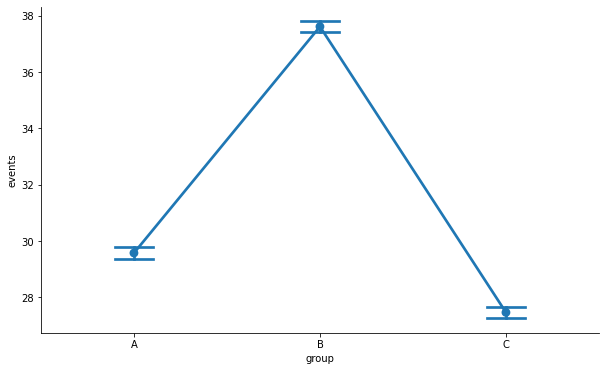

In [15]:
# Посмотрим на средние значения и их доверительные интервалы
plt.figure(figsize=(10, 6))
sns.pointplot(x='group', y='events', data=photos_df, capsize=0.2)
sns.despine();

**На основании результатов исследования принимаем решение использовать ```квадратные``` картинки.**

<hr>

## 2. Проверим,  как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [16]:
# Загрузим датасет №2, посмотрим на их размерность и отобразим первые 5 строк
button_df = pd.read_csv('experiment_buttoncsv.csv')
print(f'Размерность данных "experiment_button" - {button_df.shape}')
button_df.head()

Размерность данных "experiment_button" - (100000, 4)


,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


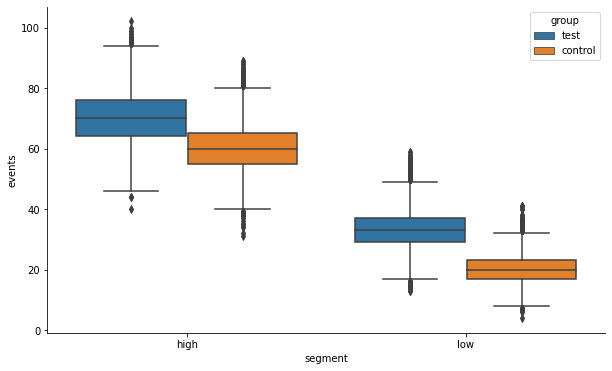

In [17]:
# Визуализурем данные по группам
plt.figure(figsize=(10, 6))
sns.boxplot(x='segment', y='events', hue='group', data=button_df)
sns.despine();

In [18]:
# Проведем многофакторный ANOVA
pg.anova(data=button_df, dv='events', between=['group', 'segment'])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864120,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377486,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


**Результат анализа позволяет сделать вывод что значим как эффект обоих факторов, так и их взаимодействие.**

Для последующих сравнений между группами соединим колонки ```group``` и ```segment``` в ```combination```, чтобы потом передать аргумент в pairwise_tukey

In [19]:
# Создадим дополнительный столбец
button_df['combination'] = button_df['group'] + '\\' + button_df['segment']
button_df.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test\high
1,96723,test,high,71.0,test\high
2,68719,test,high,80.0,test\high
3,50399,test,high,80.0,test\high
4,95613,test,high,78.0,test\high


In [20]:
# Используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия
pairwise_tukeyhsd(button_df.events, button_df.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control\high,control\low,-39.9392,0.001,-40.1073,-39.7711,True
control\high,test\high,9.9677,0.001,9.7551,10.1803,True
control\high,test\low,-26.9449,0.001,-27.113,-26.7768,True
control\low,test\high,49.9069,0.001,49.7388,50.075,True
control\low,test\low,12.9944,0.001,12.888,13.1007,True
test\high,test\low,-36.9126,0.001,-37.0807,-36.7445,True


- Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой
- Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13
- Разница между control/high и test/high составила около 10

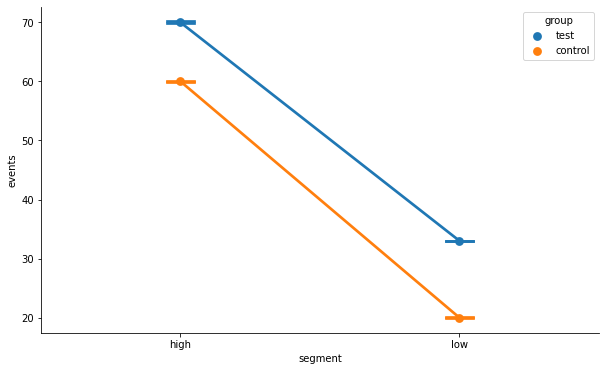

In [21]:
# Визуализируем результаты теста
plt.figure(figsize=(10, 6))
sns.pointplot(x='segment', y='events', hue='group', data=button_df, capsize=0.1)
sns.despine();

**Таким образом, фактор ```group``` оказался значимым, фактор ```segment``` – значимым, их взаимодействие – значимо. Судя по графику, для всех групп среднее значение events увеличилось, поэтому принимаем решение использовать новую версию кнопки.**